<a href="https://colab.research.google.com/github/pdiggidy/DataChallenge2/blob/main/Prohpet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Show Normal Years vs Covid Years

<ipython-input-3-c05e6c902093>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df["y"] = date_counts["year"]
<ipython-input-3-c05e6c902093>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df["y"] = date_counts["year"]


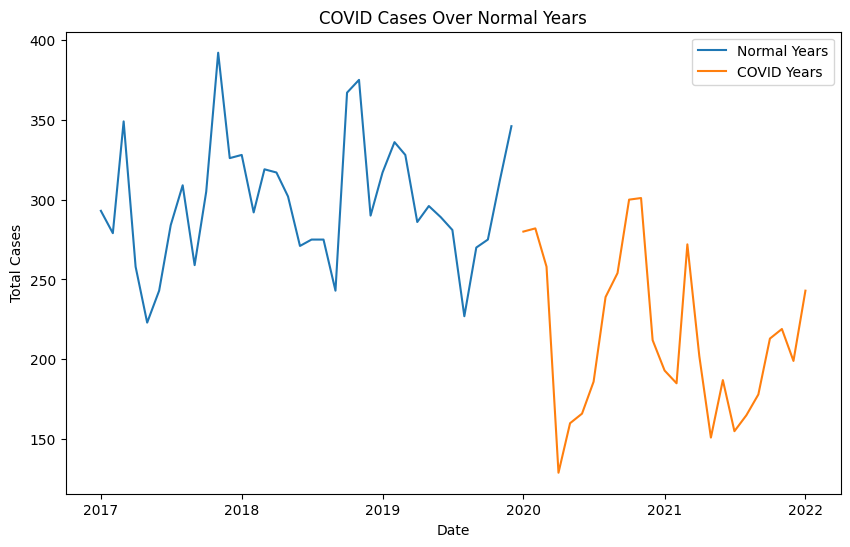

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Month_num'] = df['Month'].dt.month.astype(int)
df['year_num'] = df['Month'].dt.year.astype(int)
# Rename the columns
df = df.rename(columns={'Month_num': 'm', 'year_num': 'year'})

# create 'ds' and convert it to datetime format
df['ds'] = pd.to_datetime(df['m'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y')

# Define the start and end dates of the normal years
normal_start_date = pd.to_datetime('2017-01-01')
normal_end_date = pd.to_datetime('2019-12-31')

# Subset the DataFrame for the normal years
normal_df = df[(df['ds'] >= normal_start_date) & (df['ds'] <= normal_end_date)]

# create y
date_counts = normal_df.groupby('ds').transform('count')
normal_df["y"] = date_counts["year"]

# Subset the DataFrame for the COVID time period
covid_start_date = pd.to_datetime('2020-01-01')
covid_end_date = pd.to_datetime('2022-01-01')
covid_df = df[(df['ds'] >= covid_start_date) & (df['ds'] <= covid_end_date)]

# create y
date_counts = covid_df.groupby('ds').transform('count')
covid_df["y"] = date_counts["year"]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(normal_df['ds'], normal_df['y'], label='Normal Years')
plt.plot(covid_df['ds'], covid_df['y'], label='COVID Years')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('COVID Cases Over Normal Years')
plt.legend()
plt.show()

# Prophet with imputed data from covid - Per LSOA code (old)


In [ ]:
#unemployment data
df2 = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/unemployment.csv.csv")
df2 = df2.rename(columns={'Unit': 'ds', '%': 'unemployment %'})
df2['ds'] = pd.to_datetime(df2['ds'])
#forecasted unemployment data
df3 = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/forecast%20unemployment.csv")
df3 = df3.rename(columns={'Unit': 'ds', '%': 'unemployment %'})
df3['ds'] = pd.to_datetime(df3['ds'])

unemployment_df = pd.concat([df2, df3]).reset_index(drop=True)
unemployment_df

,ds,unemployment %
0,2010-12-01,7.9
1,2011-01-01,7.8
2,2011-02-01,7.8
3,2011-03-01,7.7
4,2011-04-01,7.8
...,...,...
154,2023-08-01,4.2
155,2023-09-01,4.2
156,2023-10-01,4.4
157,2023-11-01,4.4


In [ ]:
def unemployment(ds):
    date = pd.to_datetime(ds)

    if imputed_df[imputed_df['ds'] >= date].empty:
        return (unemployment_df[unemployment_df['ds'] >= date]['unemployment %']).values[0]
    else:
        return (imputed_df[imputed_df['ds'] >= date]['unemployment %']).values[0]

    return 0

## baseline (old)

In [ ]:
# Load the data
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Month_num'] = df['Month'].dt.month.astype(int)
df['year_num'] = df['Month'].dt.year.astype(int)
df = df.rename(columns={'Month_num': 'm', 'year_num': 'year'})

# create 'ds' and convert it to datetime format
df['ds'] = pd.to_datetime(df['m'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y')
df = df[df['ds'] <  pd.to_datetime('2020-01-01')]
print(df.shape)

# Create a list of unique LSOA codes in the data (will be looped over)
lsoa_codes = df['LSOA code'].unique()

# Create an empty DataFrame to store the forecasts
forecast_all = pd.DataFrame()

# Loop over each LSOA code and generate a separate forecast for each one
for lsoa_code in lsoa_codes:
    print(lsoa_code)
    # Filter the data for the current LSOA code
    df_lsoa = df[df['LSOA code'] == lsoa_code].copy().reset_index(drop=True)

    # create y
    date_counts = df_lsoa.groupby('ds').transform('count')
    df_lsoa["y"] = date_counts["year"]

    # Add unemployment data
    df_lsoa = pd.merge(df_lsoa, unemployment_df, on='ds', how='left')  # Left join

    # Create a new DataFrame that includes all months from 2020-01-01 to 2023-03-01
    new_df2 = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', end='2023-03-01', freq='MS')})

    # Compute the average for each month using data from previous years
    new_df2['y'] = np.nan
    for idx, row in new_df2.iterrows():
        month = row['ds'].month
        avg = df_lsoa[df_lsoa['ds'].dt.month == month]['y'].mean() #* (1 - row['weights'])
        avg = int(avg)
        new_df2.loc[idx, 'y'] = avg
        new_df2.loc[idx, 'LSOA code'] = lsoa_code

    new_df2['y'] = new_df2['y'].astype(int)

    # Add unemployment data
    new_df2 = pd.merge(new_df2, unemployment_df, on='ds', how='left')  # Left join

    # Create a new DataFrame with expanded rows
    expanded_df = pd.DataFrame()
    for index, row in new_df2.iterrows():
        rows = pd.DataFrame({'ds': [row['ds']] * row['y'],
                            'y': [row['y']] * row['y'],
                             'LSOA code': [row['LSOA code']] * row['y'],
                             'unemployment %': [row['unemployment %']] * row['y']})
        expanded_df = pd.concat([expanded_df, rows], ignore_index=True)

    # merge dfs
    imputed_df = pd.concat([df_lsoa, expanded_df[['ds', 'y', 'LSOA code', 'unemployment %']]], axis=0)
    imputed_df = imputed_df.reset_index(drop=True)


    #source from https://facebook.github.io/prophet/docs/quick_start.html#python-api
    #prophet dataframe
    prohpet_df = imputed_df[['ds', 'y', 'unemployment %']]
    m = Prophet()
    #m = Prophet(seasonality_mode='multiplicative')
    #m.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Monthly seasonality with a period of approximately 30.5 days
    #m.add_regressor('unemployment %')
    m.fit(prohpet_df)

    # Create a new DataFrame with 3 month forecast
    future = m.make_future_dataframe(periods=3, freq='M')
    #future['unemployment %'] = future['ds'].apply(unemployment)

    # Generate the forecasts for the current LSOA code
    forecast = m.predict(future)

    # fig1 = m.plot(forecast)

    # fig2 = m.plot_components(forecast)

    # plot_plotly(m, forecast)
    # plot_components_plotly(m, forecast)

    # Add a column to the forecast DataFrame to indicate the current LSOA code
    forecast['LSOA code'] = lsoa_code

    # Append the forecasts for the current LSOA code to the overall forecast DataFrame
    forecast_all = forecast_all.append(forecast)


forecast_all = forecast_all.reset_index(drop=True)
# Write the forecast DataFrame to a CSV file
forecast_all.to_csv('my_forecasts_baseline.csv', index=False)

(35861, 16)
E01000248


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ql8oujqz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/x7l8132d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56641', 'data', 'file=/tmp/tmpfbl5de57/ql8oujqz.json', 'init=/tmp/tmpfbl5de57/x7l8132d.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelhc4i_w6f/prophet_model-20230521121405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000249


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/4lrpxmx7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ns7vxe0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5166', 'data', 'file=/tmp/tmpfbl5de57/4lrpxmx7.json', 'init=/tmp/tmpfbl5de57/ns7vxe0p.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelxb2_1hgx/prophet_model-20230521121406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Futu

E01000254


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ai3gjq9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/8_2_yq2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69482', 'data', 'file=/tmp/tmpfbl5de57/ai3gjq9i.json', 'init=/tmp/tmpfbl5de57/8_2_yq2l.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelvpb1ktyk/prophet_model-20230521121406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000292


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/spj79j9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16565', 'data', 'file=/tmp/tmpfbl5de57/iswdhct9.json', 'init=/tmp/tmpfbl5de57/spj79j9q.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeli2ur7l2z/prophet_model-20230521121407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000293


12:14:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/jagqpe7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/rxc7a11r.json
DEBUG:cmdstanpy:idx 0


E01000167


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9277', 'data', 'file=/tmp/tmpfbl5de57/jagqpe7i.json', 'init=/tmp/tmpfbl5de57/rxc7a11r.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelfowc8ms4/prophet_model-20230521121407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:i

E01000251


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8194', 'data', 'file=/tmp/tmpfbl5de57/5tlxdv28.json', 'init=/tmp/tmpfbl5de57/6sdgocxo.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeldfcxht7w/prophet_model-20230521121408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:i

E01000252


12:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zzbpo1zk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/hcw2hhgx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89353', 'data', 'file=/tmp/tmpfbl5de57/zzbpo1zk.json', 'init=/tmp/tmpfbl5de57/hcw2hhgx.json', 'output', 

E01000166


12:14:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bfic8xo3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/68q3c2ao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54306', 'data', 'file=/tmp/tmpfbl5de57/bfic8xo3.json', 'init=/tmp/tmpfbl5de57/68q3c2ao.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelgf6fkcwu/prophet_model-20230521121409.csv', 'method=optimize', 

E01000168


INFO:cmdstanpy:Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/nlaiz8j3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/62lem8l7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98225', 'data', 'file=/tmp/tmpfbl5de57/nlaiz8j3.json', 'init=/tmp/tmpfbl5de57/62lem8l7.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model28425tk9/prophet_mode

E01000169


12:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/xcudws4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/o25dek8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34664', 'data', 'file=/tmp/tmpfbl5de57/xcudws4c.json', 'init=/tmp/tmpfbl5de57/o25dek8w.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelh2q8xaaq/prophet_model-20230521121409.csv', 'method=optimize', 

E01000285


12:14:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/s8j7w4dt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/gqzvvi7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21939', 'data', 'file=/tmp/tmpfbl5de57/s8j7w4dt.json', 'init=/tmp/tmpfbl5de57/gqzvvi7y.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelm4ullwp1/prophet_model-20230521121409.csv', 'method=optimize', 

E01000289


INFO:cmdstanpy:Chain [1] start processing
12:14:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/7ljhcy_f.json


E01000291


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/fgihbqpb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87960', 'data', 'file=/tmp/tmpfbl5de57/7ljhcy_f.json', 'init=/tmp/tmpfbl5de57/fgihbqpb.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelrki8mx6g/prophet_model-20230521121410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000267


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2992', 'data', 'file=/tmp/tmpfbl5de57/sm3axw86.json', 'init=/tmp/tmpfbl5de57/4pikqiel.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model5u6h64hx/prophet_model-20230521121410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/psggz40n.json
DEBUG

E01000268


12:14:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000270


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/z6h6a0fp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/8yti8uvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92265', 'data', 'file=/tmp/tmpfbl5de57/z6h6a0fp.json', 'init=/tmp/tmpfbl5de57/8yti8uvv.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model7_6i8f23/prophet_model-20230521121411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000170


12:14:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/529_4_mu.json


E01000171


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/tdxcowdn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17744', 'data', 'file=/tmp/tmpfbl5de57/529_4_mu.json', 'init=/tmp/tmpfbl5de57/tdxcowdn.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelolh0db0i/prophet_model-20230521121412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000173


12:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/vgjpxb_t.json


E01000174


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/vukt9u1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13350', 'data', 'file=/tmp/tmpfbl5de57/vgjpxb_t.json', 'init=/tmp/tmpfbl5de57/vukt9u1w.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modellwf6l6v3/prophet_model-20230521121412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000228


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/1mlum6y3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/hixasjh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44759', 'data', 'file=/tmp/tmpfbl5de57/1mlum6y3.json', 'init=/tmp/tmpfbl5de57/hixasjh1.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeliq2ziu51/prophet_model-20230521121413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000253


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/k6nf82vg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/f2g7yxrk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30303', 'data', 'file=/tmp/tmpfbl5de57/k6nf82vg.json', 'init=/tmp/tmpfbl5de57/f2g7yxrk.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelbi9q77hr/prophet_model-20230521121413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000280


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_du2wdxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5a5q16xc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12879', 'data', 'file=/tmp/tmpfbl5de57/_du2wdxu.json', 'init=/tmp/tmpfbl5de57/5a5q16xc.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelvb7z88x7/prophet_model-20230521121414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000286


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/v5hyhk_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/qm6bqhpl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12441', 'data', 'file=/tmp/tmpfbl5de57/v5hyhk_7.json', 'init=/tmp/tmpfbl5de57/qm6bqhpl.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelu2k_7ekd/prophet_model-20230521121415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000290


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/fqch8xfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/6thsek3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30862', 'data', 'file=/tmp/tmpfbl5de57/fqch8xfd.json', 'init=/tmp/tmpfbl5de57/6thsek3c.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model6po076i4/prophet_model-20230521121416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000271


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/uapzpwl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3mi8g_oc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56013', 'data', 'file=/tmp/tmpfbl5de57/uapzpwl4.json', 'init=/tmp/tmpfbl5de57/3mi8g_oc.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model1bi7wedr/prophet_model-20230521121416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000272


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/r1g6n36l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/76gc84wx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47652', 'data', 'file=/tmp/tmpfbl5de57/r1g6n36l.json', 'init=/tmp/tmpfbl5de57/76gc84wx.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelkbwuw24j/prophet_model-20230521121417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000273


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/rt96rg85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/jqv118eu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40064', 'data', 'file=/tmp/tmpfbl5de57/rt96rg85.json', 'init=/tmp/tmpfbl5de57/jqv118eu.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelrdls_5td/prophet_model-20230521121417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000282


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/eozdmrnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/px3kfkiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82007', 'data', 'file=/tmp/tmpfbl5de57/eozdmrnf.json', 'init=/tmp/tmpfbl5de57/px3kfkiv.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model6bk5ha1i/prophet_model-20230521121418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000116


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53027', 'data', 'file=/tmp/tmpfbl5de57/r2fqh9yr.json', 'init=/tmp/tmpfbl5de57/70h1xym0.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model3cph8y6c/prophet_model-20230521121418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/lgvbmysc.json
DEBU

E01000120


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93670', 'data', 'file=/tmp/tmpfbl5de57/lgvbmysc.json', 'init=/tmp/tmpfbl5de57/tk7t1vlx.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_models30m0hvl/prophet_model-20230521121419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000122


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6418', 'data', 'file=/tmp/tmpfbl5de57/xgqsp8wo.json', 'init=/tmp/tmpfbl5de57/fcdk6hs7.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeld6peilxi/prophet_model-20230521121419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

E01000117


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/019mdec8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32029', 'data', 'file=/tmp/tmpfbl5de57/k98pu_kw.json', 'init=/tmp/tmpfbl5de57/019mdec8.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelhsgx0r_f/prophet_model-20230521121419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000118


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/sx84tkop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2962', 'data', 'file=/tmp/tmpfbl5de57/3ya41bro.json', 'init=/tmp/tmpfbl5de57/sx84tkop.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelv5ajs498/prophet_model-20230521121420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000121


12:14:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/i7jl8v_f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ixe6t94l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37265', 'data', 'file=/tmp/tmpfbl5de57/i7jl8v_f.json', 'init=/tmp/tmpfbl5de57/ixe6t94l.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model6dgmleg3/prophet_model-20230521121420.csv', 'method=optimize', 

E01000123


12:14:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bhv4yu_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/v9h68tgm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


E01000124


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55023', 'data', 'file=/tmp/tmpfbl5de57/bhv4yu_e.json', 'init=/tmp/tmpfbl5de57/v9h68tgm.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeloo247wp8/prophet_model-20230521121421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/91i2z0r1.json
DEBU

E01000266


12:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/x8npqiji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ue45x9b6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48885', 'data', 'file=/tmp/tmpfbl5de57/x8npqiji.json', 'init=/tmp/tmpfbl5de57/ue45x9b6.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model1gzoo5bw/prophet_model-20230521121421.csv', 'method=optimize', 

E01000274


12:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/yy28yyh0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/0qd8e1z1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18452', 'data', 'file=/tmp/tmpfbl5de57/yy28yyh0.json', 'init=/tmp/tmpfbl5de57/0qd8e1z1.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model5tsze2ox/prophet_model-20230521121421.csv', 'method=optimize', 

E01000320


12:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/291uogqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/i5lxxysh.json
DEBUG:cmdstanpy:idx 0


E01000322


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92547', 'data', 'file=/tmp/tmpfbl5de57/291uogqb.json', 'init=/tmp/tmpfbl5de57/i5lxxysh.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model90jcnpi3/prophet_model-20230521121422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000275


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76555', 'data', 'file=/tmp/tmpfbl5de57/zn1i6w6x.json', 'init=/tmp/tmpfbl5de57/mf8mhmyw.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeltpdvjlj_/prophet_model-20230521121422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000277


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28333', 'data', 'file=/tmp/tmpfbl5de57/0k3hmuzb.json', 'init=/tmp/tmpfbl5de57/gkfk6boj.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modellrofxtda/prophet_model-20230521121422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000283


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67863', 'data', 'file=/tmp/tmpfbl5de57/3z486ssm.json', 'init=/tmp/tmpfbl5de57/ccg_9glb.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelxapw1gus/prophet_model-20230521121423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000284


12:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zeepc79c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/tpmzqsap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5489', 'data', 'file=/tmp/tmpfbl5de57/zeepc79c.json', 'init=/tmp/tmpfbl5de57/tpmzqsap.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelw92blp1h/prophet_model-20230521121423.csv', 'method=optimize', '

E01000321


12:14:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/g2j0y8gr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/irjjcvk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10159', 'data', 'file=/tmp/tmpfbl5de57/g2j0y8gr.json', 'init=/tmp/tmpfbl5de57/irjjcvk4.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelllczhk91/prophet_model-20230521121424.csv', 'method=optimize', 

E01000229


12:14:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ikgwfxvs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/84ye4_lb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55820', 'data', 'file=/tmp/tmpfbl5de57/ikgwfxvs.json', 'init=/tmp/tmpfbl5de57/84ye4_lb.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modely45nem3a/prophet_model-20230521121424.csv', 'method=optimize', 

E01000230


12:14:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/se_woqe_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/b44anlkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58445', 'data', 'file=/tmp/tmpfbl5de57/se_woqe_.json', 'init=/tmp/tmpfbl5de57/b44anlkw.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelmrb1_3v7/prophet_model-20230521121424.csv', 'method=optimize', 

E01000231


12:14:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/9fvcvc75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/q6w2ibeb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76688', 'data', 'file=/tmp/tmpfbl5de57/9fvcvc75.json', 'init=/tmp/tmpfbl5de57/q6w2ibeb.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelirxzlucf/prophet_model-20230521121425.csv', 'method=optimize', 

E01000232


12:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/vc8dikao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/n1nrivl5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64046', 'data', 'file=/tmp/tmpfbl5de57/vc8dikao.json', 'init=/tmp/tmpfbl5de57/n1nrivl5.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelevw6v77_/prophet_model-20230521121425.csv', 'method=optimize', 

E01000233


12:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/aaum96bb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/mq83zjvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52573', 'data', 'file=/tmp/tmpfbl5de57/aaum96bb.json', 'init=/tmp/tmpfbl5de57/mq83zjvx.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelhibl2qsz/prophet_model-20230521121425.csv', 'method=optimize', 

E01000186


12:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ds_nx_92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/csqogu9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87021', 'data', 'file=/tmp/tmpfbl5de57/ds_nx_92.json', 'init=/tmp/tmpfbl5de57/csqogu9y.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelv7r_02xs/prophet_model-20230521121426.csv', 'method=optimize', 

E01000187


12:14:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/565hpewc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/wi8tbv9s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50857', 'data', 'file=/tmp/tmpfbl5de57/565hpewc.json', 'init=/tmp/tmpfbl5de57/wi8tbv9s.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model8c_bhsox/prophet_model-20230521121426.csv', 'method=optimize', 

E01000188


12:14:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zuwo5qb3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/i_v2cqvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71600', 'data', 'file=/tmp/tmpfbl5de57/zuwo5qb3.json', 'init=/tmp/tmpfbl5de57/i_v2cqvi.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelh2nrcoxs/prophet_model-20230521121426.csv', 'method=optimize', 

E01000189


INFO:cmdstanpy:Chain [1] start processing
12:14:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/seu_1lge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/d5171wrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23654', 'data', 'file=/tmp/tmpfbl5de57/seu_1lge.json', 'init=/tmp/tmpfbl5de57/d5171wrh.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelhahrjtb4/prophet_mode

E01000190


12:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/oqxppxm8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/s3sve_3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


E01000191


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84900', 'data', 'file=/tmp/tmpfbl5de57/oqxppxm8.json', 'init=/tmp/tmpfbl5de57/s3sve_3i.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeleebvruhv/prophet_model-20230521121427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/hnvwp7bk.json
DEBU

E01000158


INFO:cmdstanpy:Chain [1] start processing
12:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5ruuvq4v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zevatlgw.json


E01000159


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77285', 'data', 'file=/tmp/tmpfbl5de57/5ruuvq4v.json', 'init=/tmp/tmpfbl5de57/zevatlgw.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelyw77vkgj/prophet_model-20230521121428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000160


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/nn0s67hd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/29jkbe8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73950', 'data', 'file=/tmp/tmpfbl5de57/nn0s67hd.json', 'init=/tmp/tmpfbl5de57/29jkbe8p.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelxkk1btwg/prophet_model-20230521121428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000161


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/for2ctbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/87mlqun2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80117', 'data', 'file=/tmp/tmpfbl5de57/for2ctbf.json', 'init=/tmp/tmpfbl5de57/87mlqun2.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelcii0iwn_/prophet_model-20230521121429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000162


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/2b6d78_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3n9qtav4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65398', 'data', 'file=/tmp/tmpfbl5de57/2b6d78_d.json', 'init=/tmp/tmpfbl5de57/3n9qtav4.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelp8l89_bt/prophet_model-20230521121430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000324


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/yyige8m9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ax_jjo6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81331', 'data', 'file=/tmp/tmpfbl5de57/yyige8m9.json', 'init=/tmp/tmpfbl5de57/ax_jjo6v.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model4dqndlaz/prophet_model-20230521121431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000256


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/408crrh6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/n0jag4_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=322', 'data', 'file=/tmp/tmpfbl5de57/408crrh6.json', 'init=/tmp/tmpfbl5de57/n0jag4_n.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model0bhjy0xl/prophet_model-20230521121431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seaso

E01000258


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39575', 'data', 'file=/tmp/tmpfbl5de57/590g78ax.json', 'init=/tmp/tmpfbl5de57/xcubm58w.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelfbjx_033/prophet_model-20230521121432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000263


12:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/m3e5uqii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/cfv1bqex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


E01000264


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95127', 'data', 'file=/tmp/tmpfbl5de57/m3e5uqii.json', 'init=/tmp/tmpfbl5de57/cfv1bqex.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model07h1oqdq/prophet_model-20230521121432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/lh3e_1zb.json
DEBU

E01000255


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9250', 'data', 'file=/tmp/tmpfbl5de57/lh3e_1zb.json', 'init=/tmp/tmpfbl5de57/y10y7imd.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelsk4iwrq3/prophet_model-20230521121433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

E01000257


INFO:cmdstanpy:Chain [1] start processing
12:14:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/nhev3msa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/asv7i86v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6024', 'data', 'file=/tmp/tmpfbl5de57/nhev3msa.json', 'init=/tmp/tmpfbl5de57/asv7i86v.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model4f15o_e4/prophet_model

E01000261


12:14:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/gcjtk556.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/j9xdy5i5.json
DEBUG:cmdstanpy:idx 0


E01000262


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61830', 'data', 'file=/tmp/tmpfbl5de57/gcjtk556.json', 'init=/tmp/tmpfbl5de57/j9xdy5i5.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelqxsgml6p/prophet_model-20230521121434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000193


12:14:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/6j70mbga.json


E01000194


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/j8tbkwh8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64226', 'data', 'file=/tmp/tmpfbl5de57/6j70mbga.json', 'init=/tmp/tmpfbl5de57/j8tbkwh8.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelnz8uzhg6/prophet_model-20230521121434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000226


12:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/imdlvr9g.json


E01000227


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/7evja69z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43926', 'data', 'file=/tmp/tmpfbl5de57/imdlvr9g.json', 'init=/tmp/tmpfbl5de57/7evja69z.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelnjadkmvk/prophet_model-20230521121435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000299


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/kopnmr9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/4dbba_zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51183', 'data', 'file=/tmp/tmpfbl5de57/kopnmr9j.json', 'init=/tmp/tmpfbl5de57/4dbba_zd.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelfl0yemp6/prophet_model-20230521121436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000302


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/x_b_m_2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/yz4u2i3z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92729', 'data', 'file=/tmp/tmpfbl5de57/x_b_m_2n.json', 'init=/tmp/tmpfbl5de57/yz4u2i3z.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelqo053_7y/prophet_model-20230521121436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000317


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/2e5qiieq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bzahqsjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96486', 'data', 'file=/tmp/tmpfbl5de57/2e5qiieq.json', 'init=/tmp/tmpfbl5de57/bzahqsjd.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelju96dyem/prophet_model-20230521121437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000318


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ws51ojyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/i8jkb7xl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19675', 'data', 'file=/tmp/tmpfbl5de57/ws51ojyl.json', 'init=/tmp/tmpfbl5de57/i8jkb7xl.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelyqpa5rre/prophet_model-20230521121438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000323


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/85weeyi4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/pvhwoouf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25803', 'data', 'file=/tmp/tmpfbl5de57/85weeyi4.json', 'init=/tmp/tmpfbl5de57/pvhwoouf.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelr6ai7ty0/prophet_model-20230521121439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000278


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/7g5kr_3w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5fhvmigo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79827', 'data', 'file=/tmp/tmpfbl5de57/7g5kr_3w.json', 'init=/tmp/tmpfbl5de57/5fhvmigo.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model4f4ngk7o/prophet_model-20230521121440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000301


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bxa9skvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11224', 'data', 'file=/tmp/tmpfbl5de57/frhdpq1a.json', 'init=/tmp/tmpfbl5de57/bxa9skvc.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeleec462ux/prophet_model-20230521121440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000303


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/8laxvf96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15368', 'data', 'file=/tmp/tmpfbl5de57/t02n4k1m.json', 'init=/tmp/tmpfbl5de57/8laxvf96.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelmw4lxswg/prophet_model-20230521121441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000304


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/qef_3g14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/v5alx3dp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3023', 'data', 'file=/tmp/tmpfbl5de57/qef_3g14.json', 'init=/tmp/tmpfbl5de57/v5alx3dp.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model64_mcl61/prophet_model-20230521121441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Futu

E01000130


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/x7ly8x6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/gbae6dv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61264', 'data', 'file=/tmp/tmpfbl5de57/x7ly8x6x.json', 'init=/tmp/tmpfbl5de57/gbae6dv_.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelfbilokf4/prophet_model-20230521121442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000234


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/a2lwtd0w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/kv86xv8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6384', 'data', 'file=/tmp/tmpfbl5de57/a2lwtd0w.json', 'init=/tmp/tmpfbl5de57/kv86xv8y.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeleyiyx3pa/prophet_model-20230521121443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Futu

E01000235


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_2yt6fte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/dg362srl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13519', 'data', 'file=/tmp/tmpfbl5de57/_2yt6fte.json', 'init=/tmp/tmpfbl5de57/dg362srl.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelsvvb0cl_/prophet_model-20230521121444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000156


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/f07x027x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/u5xlggek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46881', 'data', 'file=/tmp/tmpfbl5de57/f07x027x.json', 'init=/tmp/tmpfbl5de57/u5xlggek.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeljbdpawwc/prophet_model-20230521121445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000157


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/469ec0z7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/rjtykshe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18609', 'data', 'file=/tmp/tmpfbl5de57/469ec0z7.json', 'init=/tmp/tmpfbl5de57/rjtykshe.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelyy351kuj/prophet_model-20230521121445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000163


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/e38r9_xb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/xxrbp8wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92178', 'data', 'file=/tmp/tmpfbl5de57/e38r9_xb.json', 'init=/tmp/tmpfbl5de57/xxrbp8wl.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model9cbrsp1f/prophet_model-20230521121446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000164


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/9lpm88rt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/7tumg9lo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40220', 'data', 'file=/tmp/tmpfbl5de57/9lpm88rt.json', 'init=/tmp/tmpfbl5de57/7tumg9lo.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model_bv2kgyj/prophet_model-20230521121446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000315


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/28e0v0ob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/2h2hafd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77826', 'data', 'file=/tmp/tmpfbl5de57/28e0v0ob.json', 'init=/tmp/tmpfbl5de57/2h2hafd5.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelst9lnh2y/prophet_model-20230521121447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000197


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_bvxze62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ow6b0q27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82742', 'data', 'file=/tmp/tmpfbl5de57/_bvxze62.json', 'init=/tmp/tmpfbl5de57/ow6b0q27.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelpxp2h5uw/prophet_model-20230521121448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000295


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5e0xjmdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/nuufcasb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86736', 'data', 'file=/tmp/tmpfbl5de57/5e0xjmdv.json', 'init=/tmp/tmpfbl5de57/nuufcasb.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelvbqup19i/prophet_model-20230521121449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000296


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ztlfmbk6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18020', 'data', 'file=/tmp/tmpfbl5de57/oahgxsbt.json', 'init=/tmp/tmpfbl5de57/ztlfmbk6.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelzgcg8o5k/prophet_model-20230521121449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000298


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ch8y_1id.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/b2ssq546.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60294', 'data', 'file=/tmp/tmpfbl5de57/ch8y_1id.json', 'init=/tmp/tmpfbl5de57/b2ssq546.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelcvv1pp5c/prophet_model-20230521121450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000131


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/f3ngyfxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/e2rj51hf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18842', 'data', 'file=/tmp/tmpfbl5de57/f3ngyfxu.json', 'init=/tmp/tmpfbl5de57/e2rj51hf.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelc5ti8o3o/prophet_model-20230521121451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000134


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3__aeww2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/rnnwt901.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50553', 'data', 'file=/tmp/tmpfbl5de57/3__aeww2.json', 'init=/tmp/tmpfbl5de57/rnnwt901.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelykogxtqi/prophet_model-20230521121451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version

E01000199


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/l30odn0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/b88buh5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10246', 'data', 'file=/tmp/tmpfbl5de57/l30odn0d.json', 'init=/tmp/tmpfbl5de57/b88buh5y.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelffkk6m3r/prophet_model-20230521121452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000204


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/yj__s3ry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=289', 'data', 'file=/tmp/tmpfbl5de57/4qbz10wp.json', 'init=/tmp/tmpfbl5de57/yj__s3ry.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelj28161nc/prophet_model-20230521121452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seas

E01000259


12:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/dopi_35i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/m3uysf7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5107', 'data', 'file=/tmp/tmpfbl5de57/dopi_35i.json', 'init=/tmp/tmpfbl5de57/m3uysf7k.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelsrgbiglu/prophet_model-20230521121453.csv', 'method=optimize', '

E01000260


12:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/vnl3go_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/vc5rfth3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72366', 'data', 'file=/tmp/tmpfbl5de57/vnl3go_6.json', 'init=/tmp/tmpfbl5de57/vc5rfth3.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelf75q162m/prophet_model-20230521121453.csv', 'method=optimize', 

E01000126


12:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/24061ktq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/6g505b7l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30836', 'data', 'file=/tmp/tmpfbl5de57/24061ktq.json', 'init=/tmp/tmpfbl5de57/6g505b7l.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelhdv28kon/prophet_model-20230521121454.csv', 'method=optimize', 

E01000151


12:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/euad8doj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/tzozkxqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78097', 'data', 'file=/tmp/tmpfbl5de57/euad8doj.json', 'init=/tmp/tmpfbl5de57/tzozkxqe.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelexgxgfe_/prophet_model-20230521121454.csv', 'method=optimize', 

E01000152


<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/h68i7by_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ej1duqah.json


E01000153


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1663', 'data', 'file=/tmp/tmpfbl5de57/h68i7by_.json', 'init=/tmp/tmpfbl5de57/ej1duqah.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelvkf3ey9a/prophet_model-20230521121454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override t

E01000154


12:14:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000176


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/0qzufkun.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/lizre8w3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46645', 'data', 'file=/tmp/tmpfbl5de57/0qzufkun.json', 'init=/tmp/tmpfbl5de57/lizre8w3.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeln5ntr249/prophet_model-20230521121455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000178


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/mrjs3h7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/pot555zu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47745', 'data', 'file=/tmp/tmpfbl5de57/mrjs3h7f.json', 'init=/tmp/tmpfbl5de57/pot555zu.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model4a3va50j/prophet_model-20230521121456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000297


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/wjqsizy_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/y_1ja0nx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68695', 'data', 'file=/tmp/tmpfbl5de57/wjqsizy_.json', 'init=/tmp/tmpfbl5de57/y_1ja0nx.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modela3_a5x6d/prophet_model-20230521121456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000316


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/rk6y0tmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_y8cfhb5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23974', 'data', 'file=/tmp/tmpfbl5de57/rk6y0tmh.json', 'init=/tmp/tmpfbl5de57/_y8cfhb5.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeloxcfhtu4/prophet_model-20230521121456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000319


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/lx7up_bu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/s_j_li_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5066', 'data', 'file=/tmp/tmpfbl5de57/lx7up_bu.json', 'init=/tmp/tmpfbl5de57/s_j_li_y.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelx8ohw9yf/prophet_model-20230521121457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seas

E01000196


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ffl0_43s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/etcvvb59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22475', 'data', 'file=/tmp/tmpfbl5de57/ffl0_43s.json', 'init=/tmp/tmpfbl5de57/etcvvb59.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelo4hmuyqf/prophet_model-20230521121457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000200


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/__s3_xz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/q8_5gvbz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37948', 'data', 'file=/tmp/tmpfbl5de57/__s3_xz8.json', 'init=/tmp/tmpfbl5de57/q8_5gvbz.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelhra1nynu/prophet_model-20230521121458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000201


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ajuqw489.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zbslfq08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84346', 'data', 'file=/tmp/tmpfbl5de57/ajuqw489.json', 'init=/tmp/tmpfbl5de57/zbslfq08.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modell3_h3i6s/prophet_model-20230521121458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000202


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/jz4eni24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/xpomfl6f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76463', 'data', 'file=/tmp/tmpfbl5de57/jz4eni24.json', 'init=/tmp/tmpfbl5de57/xpomfl6f.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelj3gbqqjl/prophet_model-20230521121459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000203


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ov_sy9bj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57952', 'data', 'file=/tmp/tmpfbl5de57/q1ur8md0.json', 'init=/tmp/tmpfbl5de57/ov_sy9bj.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelyygq9aap/prophet_model-20230521121459.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000177


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/k7hkf98k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/8a98ioo9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25418', 'data', 'file=/tmp/tmpfbl5de57/k7hkf98k.json', 'init=/tmp/tmpfbl5de57/8a98ioo9.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model_3kg1pez/prophet_model-20230521121500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000179


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/2mnaxjcs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/9uidinbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26289', 'data', 'file=/tmp/tmpfbl5de57/2mnaxjcs.json', 'init=/tmp/tmpfbl5de57/9uidinbo.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelf19dyx4i/prophet_model-20230521121501.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000180


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/eh3heuje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zjff8zct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22478', 'data', 'file=/tmp/tmpfbl5de57/eh3heuje.json', 'init=/tmp/tmpfbl5de57/zjff8zct.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelb067kkqo/prophet_model-20230521121502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000181


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/aoxdk463.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zpjgjwj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5406', 'data', 'file=/tmp/tmpfbl5de57/aoxdk463.json', 'init=/tmp/tmpfbl5de57/zpjgjwj7.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelnw1a4kei/prophet_model-20230521121502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version.

E01000182


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5rd3ablg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ewcsro8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26526', 'data', 'file=/tmp/tmpfbl5de57/5rd3ablg.json', 'init=/tmp/tmpfbl5de57/ewcsro8a.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelu5rz34l_/prophet_model-20230521121503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000155


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/8jkl_nf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/46iq4ih_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63198', 'data', 'file=/tmp/tmpfbl5de57/8jkl_nf7.json', 'init=/tmp/tmpfbl5de57/46iq4ih_.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelyn9x_ku1/prophet_model-20230521121503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01033572


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/uts1hhjl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7384', 'data', 'file=/tmp/tmpfbl5de57/bug200i_.json', 'init=/tmp/tmpfbl5de57/uts1hhjl.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelzsc7rosp/prophet_model-20230521121504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

E01000239


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81625', 'data', 'file=/tmp/tmpfbl5de57/wjzlgu56.json', 'init=/tmp/tmpfbl5de57/fuyl_mrp.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelo0sjavpo/prophet_model-20230521121504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000240


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/n1a5ft3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15823', 'data', 'file=/tmp/tmpfbl5de57/q2q71a8e.json', 'init=/tmp/tmpfbl5de57/n1a5ft3g.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelxwq1gd5d/prophet_model-20230521121504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000241


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62153', 'data', 'file=/tmp/tmpfbl5de57/v3etu718.json', 'init=/tmp/tmpfbl5de57/uydged7y.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model3xwg2fuv/prophet_model-20230521121505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000237


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/jhh2la4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17712', 'data', 'file=/tmp/tmpfbl5de57/_mfgzhv1.json', 'init=/tmp/tmpfbl5de57/jhh2la4s.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelzwepdix8/prophet_model-20230521121505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000242


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46682', 'data', 'file=/tmp/tmpfbl5de57/irx2xsn9.json', 'init=/tmp/tmpfbl5de57/ho_r36qk.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelbeck8wh2/prophet_model-20230521121505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000244


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/npkusclp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51282', 'data', 'file=/tmp/tmpfbl5de57/yvgjm7_j.json', 'init=/tmp/tmpfbl5de57/npkusclp.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelw4_430s2/prophet_model-20230521121506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000245


12:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/48e0pvje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/it_82y3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56460', 'data', 'file=/tmp/tmpfbl5de57/48e0pvje.json', 'init=/tmp/tmpfbl5de57/it_82y3n.json', 'output', 

E01000183


12:15:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/jj0q6c9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/fio4l4sn.json


E01000207


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92087', 'data', 'file=/tmp/tmpfbl5de57/jj0q6c9a.json', 'init=/tmp/tmpfbl5de57/fio4l4sn.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeli_n48cy7/prophet_model-20230521121507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000208


12:15:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/l0qhq42s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/4qf1nqe4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36018', 'data', 'file=/tmp/tmpfbl5de57/l0qhq42s.json', 'init=/tmp/tmpfbl5de57/4qf1nqe4.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model0x60m2aq/prophet_model-20230521121508.csv', 'method=optimize', 

E01000210


INFO:cmdstanpy:Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000213


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/agxowyp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/dx2ymqjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22828', 'data', 'file=/tmp/tmpfbl5de57/agxowyp3.json', 'init=/tmp/tmpfbl5de57/dx2ymqjs.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model6c5i4id2/prophet_model-20230521121508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000236


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71352', 'data', 'file=/tmp/tmpfbl5de57/fmbi4nvv.json', 'init=/tmp/tmpfbl5de57/5cl7qwga.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model42v222tg/prophet_model-20230521121508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000238


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/0iexvk4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/mvzzkgbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96680', 'data', 'file=/tmp/tmpfbl5de57/0iexvk4q.json', 'init=/tmp/tmpfbl5de57/mvzzkgbn.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeluhizv0y0/prophet_model-20230521121509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000310


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/t4pt3vuy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_bds5e7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99796', 'data', 'file=/tmp/tmpfbl5de57/t4pt3vuy.json', 'init=/tmp/tmpfbl5de57/_bds5e7b.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model5l4enqqz/prophet_model-20230521121510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000311


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/c797smcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/j8nah33x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9825', 'data', 'file=/tmp/tmpfbl5de57/c797smcm.json', 'init=/tmp/tmpfbl5de57/j8nah33x.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model18cswevs/prophet_model-20230521121511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Futu

E01000205


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/85_yd3j9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3ne4xb86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19924', 'data', 'file=/tmp/tmpfbl5de57/85_yd3j9.json', 'init=/tmp/tmpfbl5de57/3ne4xb86.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model_j7bb1hm/prophet_model-20230521121512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000211


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zq7deyk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3pc292xw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84561', 'data', 'file=/tmp/tmpfbl5de57/zq7deyk5.json', 'init=/tmp/tmpfbl5de57/3pc292xw.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelkidnfpx_/prophet_model-20230521121512.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000216


12:15:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000217


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_h5xt7j5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ourpnvq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43737', 'data', 'file=/tmp/tmpfbl5de57/_h5xt7j5.json', 'init=/tmp/tmpfbl5de57/ourpnvq_.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelpz0_ait1/prophet_model-20230521121513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000306


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3sy659_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/po4s6kbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84797', 'data', 'file=/tmp/tmpfbl5de57/3sy659_t.json', 'init=/tmp/tmpfbl5de57/po4s6kbw.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelf3k3pekz/prophet_model-20230521121514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000308


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/49iqarw0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zcfaynot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10821', 'data', 'file=/tmp/tmpfbl5de57/49iqarw0.json', 'init=/tmp/tmpfbl5de57/zcfaynot.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelt7nzq_to/prophet_model-20230521121515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000312


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/wvtuq0ks.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/yanlgy6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15134', 'data', 'file=/tmp/tmpfbl5de57/wvtuq0ks.json', 'init=/tmp/tmpfbl5de57/yanlgy6z.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model8gxw92wn/prophet_model-20230521121516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000313


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/zks_xuq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/mphfkfer.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54922', 'data', 'file=/tmp/tmpfbl5de57/zks_xuq4.json', 'init=/tmp/tmpfbl5de57/mphfkfer.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelf8hu_u27/prophet_model-20230521121516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000145


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14378', 'data', 'file=/tmp/tmpfbl5de57/a84d_fws.json', 'init=/tmp/tmpfbl5de57/xkuxprgt.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelm2tf0y95/prophet_model-20230521121517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/awue0ku2.json
DEBU

E01000215


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20499', 'data', 'file=/tmp/tmpfbl5de57/awue0ku2.json', 'init=/tmp/tmpfbl5de57/0ok06o67.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelzqyen3h8/prophet_model-20230521121517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000218


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/9m_p472w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47879', 'data', 'file=/tmp/tmpfbl5de57/eoldv5b_.json', 'init=/tmp/tmpfbl5de57/9m_p472w.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelz6tlj9sb/prophet_model-20230521121517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000219


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3cquuv6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/gj1gited.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35112', 'data', 'file=/tmp/tmpfbl5de57/3cquuv6l.json', 'init=/tmp/tmpfbl5de57/gj1gited.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelczp8z5cu/prophet_model-20230521121518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000220


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ve9j8139.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_p2_jjyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81865', 'data', 'file=/tmp/tmpfbl5de57/ve9j8139.json', 'init=/tmp/tmpfbl5de57/_p2_jjyu.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelq_12r2c0/prophet_model-20230521121519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000225


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/pnqsajci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/6swi3ybz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85053', 'data', 'file=/tmp/tmpfbl5de57/pnqsajci.json', 'init=/tmp/tmpfbl5de57/6swi3ybz.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelb547rayz/prophet_model-20230521121519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000135


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/9jkcfftd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/hh4vrbsr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49247', 'data', 'file=/tmp/tmpfbl5de57/9jkcfftd.json', 'init=/tmp/tmpfbl5de57/hh4vrbsr.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modely3amjrku/prophet_model-20230521121520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000136


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/xnyemv7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91045', 'data', 'file=/tmp/tmpfbl5de57/vxmqs3m5.json', 'init=/tmp/tmpfbl5de57/xnyemv7f.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model6tajkap9/prophet_model-20230521121520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000146


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/amfptjk3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59790', 'data', 'file=/tmp/tmpfbl5de57/pfzt3scx.json', 'init=/tmp/tmpfbl5de57/amfptjk3.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelnxb1aqqi/prophet_model-20230521121521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000214


12:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/db8e97p1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/wuenufw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74087', 'data', 'file=/tmp/tmpfbl5de57/db8e97p1.json', 'init=/tmp/tmpfbl5de57/wuenufw4.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeli1nwqc_b/prophet_model-20230521121521.csv', 'method=optimize', 

E01000221


INFO:cmdstanpy:Chain [1] start processing
12:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/mksntg4d.json


E01000223


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/kvkj521o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23209', 'data', 'file=/tmp/tmpfbl5de57/mksntg4d.json', 'init=/tmp/tmpfbl5de57/kvkj521o.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model1g09glwh/prophet_model-20230521121522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000307


12:15:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bliqj29y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/yg5chgup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45631', 'data', 'file=/tmp/tmpfbl5de57/bliqj29y.json', 'init=/tmp/tmpfbl5de57/yg5chgup.json', 'output', 

E01000142


12:15:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


E01000222


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/fyntzahl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/wgqkzjee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38555', 'data', 'file=/tmp/tmpfbl5de57/fyntzahl.json', 'init=/tmp/tmpfbl5de57/wgqkzjee.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelq7zomup1/prophet_model-20230521121523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000224


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/ft30mqu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/07g214vi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70931', 'data', 'file=/tmp/tmpfbl5de57/ft30mqu7.json', 'init=/tmp/tmpfbl5de57/07g214vi.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelzjyjk_vq/prophet_model-20230521121524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000137


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/9bho9wut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/w39jq1nl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2856', 'data', 'file=/tmp/tmpfbl5de57/9bho9wut.json', 'init=/tmp/tmpfbl5de57/w39jq1nl.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model5_fxe_jm/prophet_model-20230521121524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000139


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/n87wh8rh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/1cwxxl8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40298', 'data', 'file=/tmp/tmpfbl5de57/n87wh8rh.json', 'init=/tmp/tmpfbl5de57/1cwxxl8y.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model_794r_j4/prophet_model-20230521121525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000140


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/y8abfkal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/mccwbs12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=156', 'data', 'file=/tmp/tmpfbl5de57/y8abfkal.json', 'init=/tmp/tmpfbl5de57/mccwbs12.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelm59hzwf0/prophet_model-20230521121525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000143


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/k53gti1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bwaaq449.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86881', 'data', 'file=/tmp/tmpfbl5de57/k53gti1d.json', 'init=/tmp/tmpfbl5de57/bwaaq449.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model35bjmvxr/prophet_model-20230521121526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000250


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/eub5mygl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/g7fchq6d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87787', 'data', 'file=/tmp/tmpfbl5de57/eub5mygl.json', 'init=/tmp/tmpfbl5de57/g7fchq6d.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelsae6ywl0/prophet_model-20230521121526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000246


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/6ixrhv8_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20187', 'data', 'file=/tmp/tmpfbl5de57/5obm8xwh.json', 'init=/tmp/tmpfbl5de57/6ixrhv8_.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelr96gjj46/prophet_model-20230521121527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000247


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_hh1qv5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/3svh0eld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20812', 'data', 'file=/tmp/tmpfbl5de57/_hh1qv5b.json', 'init=/tmp/tmpfbl5de57/3svh0eld.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelatgwukkt/prophet_model-20230521121527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000172


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/kgqdjr0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/mtro1of7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35208', 'data', 'file=/tmp/tmpfbl5de57/kgqdjr0g.json', 'init=/tmp/tmpfbl5de57/mtro1of7.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model90yrkvzq/prophet_model-20230521121528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000287


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_rojve4i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5p6sznnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74534', 'data', 'file=/tmp/tmpfbl5de57/_rojve4i.json', 'init=/tmp/tmpfbl5de57/5p6sznnm.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelk0jbsjar/prophet_model-20230521121528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000288


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/qc4jw5kp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/wg29buu7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65405', 'data', 'file=/tmp/tmpfbl5de57/qc4jw5kp.json', 'init=/tmp/tmpfbl5de57/wg29buu7.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model5tl2udd7/prophet_model-20230521121529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version

E01000294


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/xunibhul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/0l0p4tzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7606', 'data', 'file=/tmp/tmpfbl5de57/xunibhul.json', 'init=/tmp/tmpfbl5de57/0l0p4tzb.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelp9gcr037/prophet_model-20230521121529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version.

E01000269


12:15:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/lb5825_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/aqj4pauo.json


E01000175


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93021', 'data', 'file=/tmp/tmpfbl5de57/lb5825_s.json', 'init=/tmp/tmpfbl5de57/aqj4pauo.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeljw2yo5wk/prophet_model-20230521121530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000279


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35373', 'data', 'file=/tmp/tmpfbl5de57/7n7prr6b.json', 'init=/tmp/tmpfbl5de57/zbnqojpx.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelpu4cxsts/prophet_model-20230521121530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/u196lkn_.json
DEBU

E01000281


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26357', 'data', 'file=/tmp/tmpfbl5de57/u196lkn_.json', 'init=/tmp/tmpfbl5de57/rtkomaxg.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model5atptkq6/prophet_model-20230521121531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000115


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/38p1as9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79606', 'data', 'file=/tmp/tmpfbl5de57/tdm02g7h.json', 'init=/tmp/tmpfbl5de57/38p1as9l.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelo54a4590/prophet_model-20230521121531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000119


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9447', 'data', 'file=/tmp/tmpfbl5de57/d9x17g1z.json', 'init=/tmp/tmpfbl5de57/pewc01e4.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelvi5c93ae/prophet_model-20230521121531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:i

E01000195


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/jk7kqzaj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44107', 'data', 'file=/tmp/tmpfbl5de57/y11puu65.json', 'init=/tmp/tmpfbl5de57/jk7kqzaj.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelwqln14d7/prophet_model-20230521121532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000192


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/slgb46sy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/8hc0385d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31936', 'data', 'file=/tmp/tmpfbl5de57/slgb46sy.json', 'init=/tmp/tmpfbl5de57/8hc0385d.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelm_yoy9wa/prophet_model-20230521121532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000300


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/vdmuwq_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/p518ai_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44862', 'data', 'file=/tmp/tmpfbl5de57/vdmuwq_8.json', 'init=/tmp/tmpfbl5de57/p518ai_6.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model93l2e8zi/prophet_model-20230521121533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000276


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59312', 'data', 'file=/tmp/tmpfbl5de57/u8edul1f.json', 'init=/tmp/tmpfbl5de57/vsuz0pb6.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelz5o0457k/prophet_model-20230521121533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000132


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25808', 'data', 'file=/tmp/tmpfbl5de57/x690q9zq.json', 'init=/tmp/tmpfbl5de57/x51pxc23.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelisstfb5r/prophet_model-20230521121534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/aeiqlute.json
DEBU

E01000133


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45501', 'data', 'file=/tmp/tmpfbl5de57/aeiqlute.json', 'init=/tmp/tmpfbl5de57/jetlk0tm.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model5hirbrhe/prophet_model-20230521121534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/9ip_2uj4.json
DEBU

E01000125


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10409', 'data', 'file=/tmp/tmpfbl5de57/9ip_2uj4.json', 'init=/tmp/tmpfbl5de57/rtosvkfo.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeldfn05vd5/prophet_model-20230521121534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000127


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24145', 'data', 'file=/tmp/tmpfbl5de57/vlkbk9cr.json', 'init=/tmp/tmpfbl5de57/bc_fexb_.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modely0bkx0gp/prophet_model-20230521121535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000128


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68851', 'data', 'file=/tmp/tmpfbl5de57/2o5vu3jx.json', 'init=/tmp/tmpfbl5de57/8hked9h0.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelgv7y3i58/prophet_model-20230521121535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000129


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=186', 'data', 'file=/tmp/tmpfbl5de57/kvwdyaw3.json', 'init=/tmp/tmpfbl5de57/1voo7vhc.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeldog4rbm3/prophet_model-20230521121535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:in

E01000198


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24741', 'data', 'file=/tmp/tmpfbl5de57/55e_1b_t.json', 'init=/tmp/tmpfbl5de57/3hp7n681.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model7843k2yj/prophet_model-20230521121536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:

E01000184


12:15:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/7z02h7nm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/x8rbjdyi.json


E01000147


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64328', 'data', 'file=/tmp/tmpfbl5de57/7z02h7nm.json', 'init=/tmp/tmpfbl5de57/x8rbjdyi.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelo9y81ahg/prophet_model-20230521121536.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

E01000243


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/gnaq236l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/6n7t52_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45356', 'data', 'file=/tmp/tmpfbl5de57/gnaq236l.json', 'init=/tmp/tmpfbl5de57/6n7t52_t.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelf4951y4n/prophet_model-20230521121537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000314


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/v59svvkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/kl27ayt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25816', 'data', 'file=/tmp/tmpfbl5de57/v59svvkw.json', 'init=/tmp/tmpfbl5de57/kl27ayt3.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modell0483gvg/prophet_model-20230521121537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000206


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/d5l2tax8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/cn_3r1p5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26845', 'data', 'file=/tmp/tmpfbl5de57/d5l2tax8.json', 'init=/tmp/tmpfbl5de57/cn_3r1p5.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelu1piy5wm/prophet_model-20230521121538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_sea

E01000209


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/52xpsoru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/e_67vstq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93167', 'data', 'file=/tmp/tmpfbl5de57/52xpsoru.json', 'init=/tmp/tmpfbl5de57/e_67vstq.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model488rchb0/prophet_model-20230521121538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000212


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/u7x77kyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/n06vxy23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82363', 'data', 'file=/tmp/tmpfbl5de57/u7x77kyv.json', 'init=/tmp/tmpfbl5de57/n06vxy23.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelmtm5npxy/prophet_model-20230521121539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000150


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/h4grutnd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5un287z9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97535', 'data', 'file=/tmp/tmpfbl5de57/h4grutnd.json', 'init=/tmp/tmpfbl5de57/5un287z9.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelqi388q0u/prophet_model-20230521121539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000305


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/5fpwgb6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/jmpp3i4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38449', 'data', 'file=/tmp/tmpfbl5de57/5fpwgb6m.json', 'init=/tmp/tmpfbl5de57/jmpp3i4s.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelbg7by9tr/prophet_model-20230521121540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000141


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/xiyox9v4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84427', 'data', 'file=/tmp/tmpfbl5de57/jtxjnigj.json', 'init=/tmp/tmpfbl5de57/xiyox9v4.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelc7safr4v/prophet_model-20230521121541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily se

E01000138


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30536', 'data', 'file=/tmp/tmpfbl5de57/4kurwawe.json', 'init=/tmp/tmpfbl5de57/kp1g3bdy.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelaftx9vnn/prophet_model-20230521121541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



E01000265


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/dskwde7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/_rpn0t68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93544', 'data', 'file=/tmp/tmpfbl5de57/dskwde7t.json', 'init=/tmp/tmpfbl5de57/_rpn0t68.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model62z06t7w/prophet_model-20230521121542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000165


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/pjl9u1e_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bpryduwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99185', 'data', 'file=/tmp/tmpfbl5de57/pjl9u1e_.json', 'init=/tmp/tmpfbl5de57/bpryduwo.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelxu_94mmu/prophet_model-20230521121542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01033573


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/0ags5byj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/h7whynfu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91079', 'data', 'file=/tmp/tmpfbl5de57/0ags5byj.json', 'init=/tmp/tmpfbl5de57/h7whynfu.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelfgev2wnu/prophet_model-20230521121543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000144


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/cb_h3ifc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/lfyq5d5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53821', 'data', 'file=/tmp/tmpfbl5de57/cb_h3ifc.json', 'init=/tmp/tmpfbl5de57/lfyq5d5v.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_model6wqith9o/prophet_model-20230521121543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000309


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/dhwsetzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/bkhi5xwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10683', 'data', 'file=/tmp/tmpfbl5de57/dhwsetzy.json', 'init=/tmp/tmpfbl5de57/bkhi5xwx.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modeliw2v08za/prophet_model-20230521121544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: Fut

E01000148


12:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/wscrbipw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfbl5de57/a25rgqzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49025', 'data', 'file=/tmp/tmpfbl5de57/wscrbipw.json', 'init=/tmp/tmpfbl5de57/a25rgqzj.json', 'output', 'file=/tmp/tmpfbl5de57/prophet_modelpuldw3xl/prophet_model-20230521121545.csv', 'method=optimize', 

E01000185


12:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-231-c57124d8675f>:90: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Model with Unemployment and Seasonality (updated)

In [ ]:
def unemployment(ds):
    date = pd.to_datetime(ds)

    if df[df['ds'] >= date].empty:
        return (unemployment_df[unemployment_df['ds'] >= date]['unemployment %']).values[0]
    else:
        return (df[df['ds'] >= date]['unemployment %']).values[0]

    return 0

#unemployment data
df2 = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/unemployment.csv.csv")
df2 = df2.rename(columns={'Unit': 'ds', '%': 'unemployment %'})
df2['ds'] = pd.to_datetime(df2['ds'])
#forecasted unemployment data
df3 = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/forecast%20unemployment.csv")
df3 = df3.rename(columns={'Unit': 'ds', '%': 'unemployment %'})
df3['ds'] = pd.to_datetime(df3['ds'])

unemployment_df = merged_df = pd.concat([df2, df3]).reset_index(drop=True)
unemployment_df

,ds,unemployment %
0,2010-12-01,7.9
1,2011-01-01,7.8
2,2011-02-01,7.8
3,2011-03-01,7.7
4,2011-04-01,7.8
...,...,...
154,2023-08-01,4.2
155,2023-09-01,4.2
156,2023-10-01,4.4
157,2023-11-01,4.4


In [ ]:
#When running ward
df = pd.read_csv(r"https://raw.githubusercontent.com/pdiggidy/DataChallenge2/main/DC2Data/wards_crime_covid_adjusted_filled_rnd_gaps.csv")

In [ ]:
#When running LSOA
df = pd.read_csv(r"https://raw.githubusercontent.com/pdiggidy/DataChallenge2/main/DC2Data/lsoa_crime_covid_adjusted_filled_rnd_gaps")

In [ ]:
df['ds'] = pd.to_datetime(df['ds'])
display(df)

# Create a list of unique LSOA codes in the data (will be looped over)
lsoa_codes = df['Ward'].unique() #LSOA code or Ward

# Create an empty DataFrame to store the forecasts
forecast_all = pd.DataFrame()

# Loop over each LSOA code and generate a separate forecast for each one
for lsoa_code in lsoa_codes:
    print(lsoa_code)
    # Filter the data for the current LSOA code
    df_lsoa = df[df['Ward'] == lsoa_code].copy().reset_index(drop=True)

    # Add unemployment data
    df_lsoa = pd.merge(df_lsoa, unemployment_df, on='ds', how='left')  # Left join

    #source from https://facebook.github.io/prophet/docs/quick_start.html#python-api
    #prophet dataframe
    prohpet_df = df_lsoa[['ds', 'y', 'unemployment %']]
    #m = Prophet()
    m = Prophet(seasonality_mode='multiplicative')
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Monthly seasonality with a period of approximately 30.5 days
    #m.add_regressor('unemployment %')
    m.fit(prohpet_df)

    # Create a new DataFrame with 3 month forecast
    future = m.make_future_dataframe(periods=3, freq='M')
    #future['unemployment %'] = future['ds'].apply(unemployment)

    # Generate the forecasts for the current LSOA code
    forecast = m.predict(future)

    # Add a column to the forecast DataFrame to indicate the current LSOA code
    forecast['Ward'] = lsoa_code

    # Append the forecasts for the current LSOA code to the overall forecast DataFrame
    forecast_all = forecast_all.append(forecast)

    # fig1 = m.plot(forecast)

    # fig2 = m.plot_components(forecast)

    # plot_plotly(m, forecast)
    # plot_components_plotly(m, forecast)


forecast_all = forecast_all.reset_index(drop=True)
# Write the forecast DataFrame to a CSV file
forecast_all.to_csv('my_forecasts_regressor_and_seasonality.csv', index=False)

,ds,Ward,y
0,2010-12-01,Barnet Vale Ward,18
1,2011-01-01,Barnet Vale Ward,22
2,2011-02-01,Barnet Vale Ward,22
3,2011-03-01,Barnet Vale Ward,16
4,2011-04-01,Barnet Vale Ward,20
...,...,...,...
3523,2022-10-01,Woodhouse Ward,13
3524,2022-11-01,Woodhouse Ward,20
3525,2022-12-01,Woodhouse Ward,15
3526,2023-01-01,Woodhouse Ward,11


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/wnp087yy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/3bjaer_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17835', 'data', 'file=/tmp/tmpfqxdhxsd/wnp087yy.json', 'init=/tmp/tmpfqxdhxsd/3bjaer_e.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_model2dgt7_3b/prophet_model-20230608110625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Barnet Vale Ward
Brunswick Park Ward


<ipython-input-26-34ad053e27bc>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_all = forecast_all.append(forecast)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/zuntwz5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/9fnwqvxf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72588', 'data', 'file=/tmp/tmpfqxdhxsd/zuntwz5l.json', 'init=/tmp/tmpfqxdhxsd/9fnwqvxf.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modelny4d9yg0/prophet_model-20230608110625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:25 - cmdstanpy

Burnt Oak Ward
Childs Hill Ward


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/4impn351.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/4snmyqvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49099', 'data', 'file=/tmp/tmpfqxdhxsd/4impn351.json', 'init=/tmp/tmpfqxdhxsd/4snmyqvc.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modelqs1gid5n/prophet_model-20230608110625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_all = forecast_all.append(forecast)
INFO:prophet:Disabling wee

Colindale North Ward
Colindale South Ward


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/6w4j_own.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/kww2qfn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84831', 'data', 'file=/tmp/tmpfqxdhxsd/6w4j_own.json', 'init=/tmp/tmpfqxdhxsd/kww2qfn0.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modelfesbt8en/prophet_model-20230608110626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: Futu

Cricklewood Ward
East Barnet Ward


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/5l_etdnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/l98e8aiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66222', 'data', 'file=/tmp/tmpfqxdhxsd/5l_etdnr.json', 'init=/tmp/tmpfqxdhxsd/l98e8aiw.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_model6n27xj20/prophet_model-20230608110626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_all = forecast_all.append(forecast)
INFO:prophet:Disabling wee

East Finchley Ward
Edgware Ward


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/ktjgmyun.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/jteafjmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79957', 'data', 'file=/tmp/tmpfqxdhxsd/ktjgmyun.json', 'init=/tmp/tmpfqxdhxsd/jteafjmn.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modelc3_umf73/prophet_model-20230608110626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_all = forecast_all.append(forecast)
INFO:prophet:Disabling wee

Edgwarebury Ward
Finchley Church End Ward


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/xxz1rblo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/11pla_qr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75445', 'data', 'file=/tmp/tmpfqxdhxsd/xxz1rblo.json', 'init=/tmp/tmpfqxdhxsd/11pla_qr.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modeledy92oot/prophet_model-20230608110627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_all = forecast_all.append(forecast)
INFO:prophet:Disabling wee

Friern Barnet Ward
Garden Suburb Ward


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/xe8tok_e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/jq3kyj1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36220', 'data', 'file=/tmp/tmpfqxdhxsd/xe8tok_e.json', 'init=/tmp/tmpfqxdhxsd/jq3kyj1j.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modell5_7yqp_/prophet_model-20230608110627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: Futu

Golders Green Ward
Hendon Ward


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/grs2uj68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/i4meo4hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9458', 'data', 'file=/tmp/tmpfqxdhxsd/grs2uj68.json', 'init=/tmp/tmpfqxdhxsd/i4meo4hz.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modelx0a4i2ou/prophet_model-20230608110627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: Futur

High Barnet Ward
Mill Hill Ward


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/bulh7eis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/ayomqpcw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77416', 'data', 'file=/tmp/tmpfqxdhxsd/bulh7eis.json', 'init=/tmp/tmpfqxdhxsd/ayomqpcw.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_model88u_wbp6/prophet_model-20230608110628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_all = forecast_all.append(forecast)
INFO:prophet:Disabling wee

Totteridge & Woodside Ward
Underhill Ward


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/2swvuw_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/6_m2jy3t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97202', 'data', 'file=/tmp/tmpfqxdhxsd/2swvuw_a.json', 'init=/tmp/tmpfqxdhxsd/6_m2jy3t.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_modelglxewibl/prophet_model-20230608110628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: Futu

West Finchley Ward
West Hendon Ward


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/nzlt498b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/qn22_kil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21262', 'data', 'file=/tmp/tmpfqxdhxsd/nzlt498b.json', 'init=/tmp/tmpfqxdhxsd/qn22_kil.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_model61e2yhe9/prophet_model-20230608110629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: Futu

Whetstone Ward
Woodhouse Ward


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/17805705.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfqxdhxsd/nexfu52f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3111', 'data', 'file=/tmp/tmpfqxdhxsd/17805705.json', 'init=/tmp/tmpfqxdhxsd/nexfu52f.json', 'output', 'file=/tmp/tmpfqxdhxsd/prophet_model5vw3kduo/prophet_model-20230608110629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-26-34ad053e27bc>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_all = forecast_all.append(forecast)


In [ ]:
forecast_all[['Ward', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,Ward,ds,yhat,yhat_lower,yhat_upper
0,Barnet Vale Ward,2010-12-01,27.115361,22.143052,32.025316
1,Barnet Vale Ward,2011-01-01,22.688909,18.266904,27.417901
2,Barnet Vale Ward,2011-02-01,22.501938,17.587249,27.241844
3,Barnet Vale Ward,2011-03-01,21.010694,16.340386,25.466624
4,Barnet Vale Ward,2011-04-01,18.481902,14.051305,23.455655
...,...,...,...,...,...
3595,Woodhouse Ward,2023-01-01,12.927540,8.459335,17.504008
3596,Woodhouse Ward,2023-02-01,12.155156,7.910743,16.722952
3597,Woodhouse Ward,2023-02-28,16.696727,12.343578,21.020621
3598,Woodhouse Ward,2023-03-31,16.563736,12.231617,20.690382


# Performance Metrics on data up to Covid Years (updated)

house prices,

In [ ]:
#When running ward
df = pd.read_csv(r"https://raw.githubusercontent.com/pdiggidy/DataChallenge2/main/DC2Data/wards_crime_covid_adjusted_filled_rnd_gaps.csv")

In [ ]:
#When running LSOA
df = pd.read_csv(r"https://raw.githubusercontent.com/pdiggidy/DataChallenge2/main/DC2Data/lsoa_crime_covid_adjusted_filled_rnd_gaps")

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

df['ds'] = pd.to_datetime(df['ds'])

df = df[df['ds'].dt.year == 2019]

# Limit to data before covid for evaluation metrics
forecast_all = forecast_all[forecast_all['ds'].dt.year == 2019]

# Gets rid of duplicate rows (process for merging) removes weighting of high crimes (all equal)
unique_df = df.drop_duplicates(subset=['ds', 'Ward']) #LSOA code or Ward
unique_df

# Get predictions and actuals in one table
merged = pd.merge(forecast_all, unique_df, on=['ds', 'Ward'])
merged.columns.unique()
merged = merged[['ds', 'Ward', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]

mse = mean_squared_error(merged.y, merged.yhat)
print("Mean Squared Error (MSE):", mse)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Check if the actual values fall within the prediction intervals
coverage = np.mean((merged.y >= merged.yhat_lower) & (merged.y <= merged.yhat_upper))
print("Prediction Interval Coverage:", coverage)

r2 = r2_score(merged.y, merged.yhat)
print("R-squared (R²) Score:", r2)

# Lower SMAPE values indicate better accuracy.
forecast['ape'] = abs(merged.y - merged.yhat) / ((abs(merged.y) + abs(merged.yhat)) / 2)

smape = (forecast['ape'].mean()) * 100
print("Symmetric Mean Absolute Percentage Error:", smape)


Mean Squared Error (MSE): 11.947146310774905
RMSE: 3.456464423478839
Prediction Interval Coverage: 0.8020833333333334
R-squared (R²) Score: 0.5544187856121248
Symmetric Mean Absolute Percentage Error: 15.999830277442872


# prophet with imputed data from covid - Barnet as a whole (old)

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/pdiggidy/DataChallenge2/main/data/full_data.csv")

In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")

In [ ]:
print(df['Month'].min())
print(df['Month'].max())


2010-12
2023-02


In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/pdiggidy/DataChallenge2/main/data/full_data.csv")
df.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Crime ID,Month_x,Reported by_x,Falls within_x,Longitude_x,Latitude_x,...,Median 2003/04,Median 2004/05,Median 2005/06,Median 2006/07,Median 2007/08,Median 2008/09,Median 2009/10,Median 2010/11,Median 2011/12,Median 2012/13
0,0,0,0,0,5f2b26f18d91b49f16f23dc1a23277df19013f29ad0966...,2021-02,Metropolitan Police Service,Metropolitan Police Service,-0.201642,51.654545,...,"£31,370","£33,250","£33,340","£35,280","£36,310","£37,430","£39,040","£40,060","£41,970","£42,720"
1,1,1,1,1,b1970cadf1adc34a588989067dd9911de0db408608b4d5...,2021-02,Metropolitan Police Service,Metropolitan Police Service,-0.176710,51.649701,...,"£29,310","£30,880","£30,780","£32,420","£33,230","£34,140","£35,500","£36,340","£38,000","£38,610"
2,2,2,2,2,5ec60496426f4134d6aff206bc04936fea792a6ac49a61...,2021-02,Metropolitan Police Service,Metropolitan Police Service,-0.212993,51.648226,...,"£26,870","£28,410","£28,430","£30,050","£30,900","£31,850","£33,210","£34,090","£35,740","£36,400"
3,3,3,3,3,776515f51dd5ddb1cde50d464979c17df121b8f32239eb...,2021-02,Metropolitan Police Service,Metropolitan Police Service,-0.209312,51.643341,...,"£26,870","£28,410","£28,430","£30,050","£30,900","£31,850","£33,210","£34,090","£35,740","£36,400"
4,4,4,4,4,1164a96f9d4b1be9030577b6cdcfc3a6c7cf66e1b2fa1d...,2021-02,Metropolitan Police Service,Metropolitan Police Service,-0.210122,51.642571,...,"£24,910","£26,390","£26,460","£28,030","£28,890","£29,830","£31,180","£32,070","£33,690","£34,380"


In [ ]:
df = pd.read_csv(r"https://raw.githubusercontent.com/pdiggidy/DataChallenge2/main/data/full_data.csv")


In [ ]:
#unemployment data
df2 = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/unemployment.csv.csv")
df2 = df2.rename(columns={'Unit': 'ds', '%': 'unemployment %'})
df2['ds'] = pd.to_datetime(df2['ds'])
#forecasted unemployment data
df3 = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/forecast%20unemployment.csv")
df3 = df3.rename(columns={'Unit': 'ds', '%': 'unemployment %'})
df3['ds'] = pd.to_datetime(df3['ds'])

unemployment_df = merged_df = pd.concat([df2, df3]).reset_index(drop=True)
unemployment_df

,ds,unemployment %
0,2010-12-01,7.9
1,2011-01-01,7.8
2,2011-02-01,7.8
3,2011-03-01,7.7
4,2011-04-01,7.8
...,...,...
154,2023-08-01,4.2
155,2023-09-01,4.2
156,2023-10-01,4.4
157,2023-11-01,4.4


In [ ]:
def unemployment(ds):
    date = pd.to_datetime(ds)

    if imputed_df[imputed_df['ds'] >= date].empty:
        return (unemployment_df[unemployment_df['ds'] >= date]['unemployment %']).values[0]
    else:
        return (imputed_df[imputed_df['ds'] >= date]['unemployment %']).values[0]

    return 0

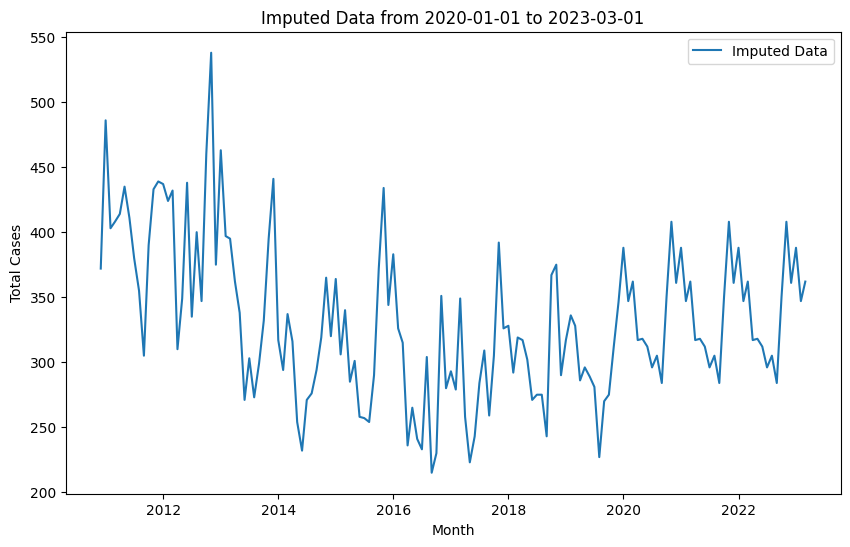

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20ewoqao/kn7hy68r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20ewoqao/h4ggxr4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98855', 'data', 'file=/tmp/tmp20ewoqao/kn7hy68r.json', 'init=/tmp/tmp20ewoqao/h4ggxr4x.json', 'output', 'file=/tmp/tmp20ewoqao/prophet_modelfjqc75b0/prophet_model-20230525171941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ValueError: ignored

In [ ]:
# Load the data
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Month_num'] = df['Month'].dt.month.astype(int)
df['year_num'] = df['Month'].dt.year.astype(int)

# Rename the columns
df = df.rename(columns={'Month_num': 'm', 'year_num': 'year'})

# create 'ds' and convert it to datetime format
df['ds'] = pd.to_datetime(df['m'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y')
df = df[df['ds'] <  pd.to_datetime('2020-01-01')]

# prohpet_df = df.groupby('ds').size().reset_index(name='y')
# print(prohpet_df)

# create y
date_counts = df.groupby('ds').transform('count')
df["y"] = date_counts["year"]

# Add unemployment data
df = pd.merge(df, unemployment_df, on='ds', how='left')  # Left join


# Create a new DataFrame that includes all months from 2020-01-01 to 2023-03-01
new_df2 = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', end='2023-03-01', freq='MS')})

# Compute the  average for each month using data from previous years
new_df2['y'] = np.nan
for idx, row in new_df2.iterrows():
    month = row['ds'].month
    avg = df[df['ds'].dt.month == month]['y'].mean() #* (1 - row['weights'])
    avg = int(avg)
    new_df2.loc[idx, 'y'] = avg

new_df2['y'] = new_df2['y'].astype(int)
# Add unemployment data
new_df2 = pd.merge(new_df2, unemployment_df, on='ds', how='left')  # Left join
new_df2

# Create a new DataFrame with expanded rows
expanded_df = pd.DataFrame()
for index, row in new_df2.iterrows():
    rows = pd.DataFrame({'ds': [row['ds']] * row['y'],
                         'y': [row['y']] * row['y'],
                         'unemployment %': [row['unemployment %']] * row['y']})
    expanded_df = pd.concat([expanded_df, rows], ignore_index=True)

# Concatenate the new DataFrame with the original DataFrame
imputed_df = pd.concat([df, expanded_df[['ds', 'y','unemployment %']]], axis=0)

# Reset the index of the concatenated DataFrame
imputed_df = imputed_df.reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(imputed_df['ds'], imputed_df['y'], label='Imputed Data')
plt.xlabel('Month')
plt.ylabel('Total Cases')
plt.title('Imputed Data from 2020-01-01 to 2023-03-01')
plt.legend()
plt.show()

#prophet dataframe
prohpet_df = imputed_df[['ds', 'y', 'unemployment %']]

# print(prohpet_df)
# print(prohpet_df.dtypes)

####################################

# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
cutoffs = pd.to_datetime(['2018-02-15', '2018-08-15', '2019-02-15'])
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prohpet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='6 months', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)



#####################################

m = Prophet()
m.add_regressor('unemployment %')
m.fit(prohpet_df)


future = m.make_future_dataframe(periods=9, freq='M')
future['unemployment %'] = future['ds'].apply(unemployment)
print(future)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

plot_plotly(m, forecast)
plot_components_plotly(m, forecast)

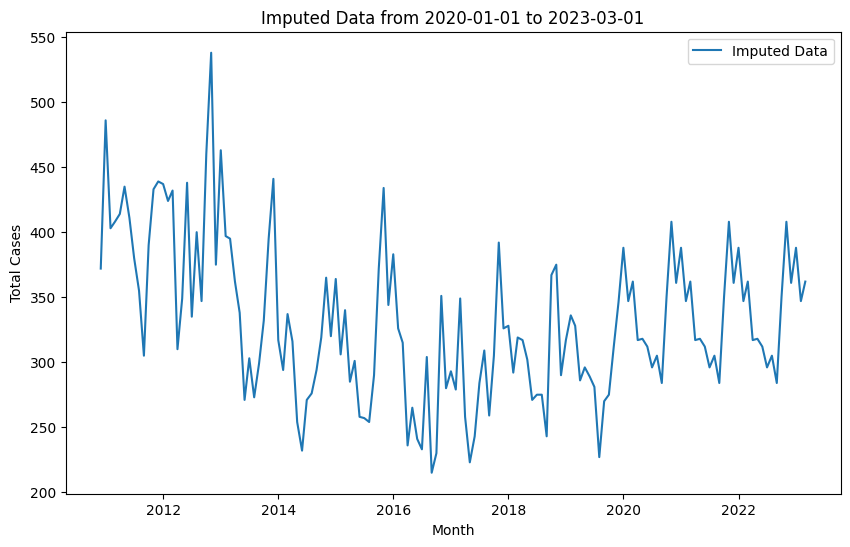

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20ewoqao/rqm3amnk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20ewoqao/bgm8jeul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94106', 'data', 'file=/tmp/tmp20ewoqao/rqm3amnk.json', 'init=/tmp/tmp20ewoqao/bgm8jeul.json', 'output', 'file=/tmp/tmp20ewoqao/prophet_modell_ed0nu6/prophet_model-20230525173012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff9d56fa920>
DEBUG:cmdstanpy:input tempfil

In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation

# Load the data
df = pd.read_csv(r"https://raw.githubusercontent.com/forcept007/burglary-date/main/burglary.csv")
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df['Month_num'] = df['Month'].dt.month.astype(int)
df['year_num'] = df['Month'].dt.year.astype(int)

# Rename the columns
df = df.rename(columns={'Month_num': 'm', 'year_num': 'year'})

# create 'ds' and convert it to datetime format
df['ds'] = pd.to_datetime(df['m'].astype(str) + '-' + df['year'].astype(str), format='%m-%Y')
df = df[df['ds'] <  pd.to_datetime('2020-01-01')]

# prohpet_df = df.groupby('ds').size().reset_index(name='y')
# print(prohpet_df)

# create y
date_counts = df.groupby('ds').transform('count')
df["y"] = date_counts["year"]

# Add unemployment data
df = pd.merge(df, unemployment_df, on='ds', how='left')  # Left join


# Create a new DataFrame that includes all months from 2020-01-01 to 2023-03-01
new_df2 = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', end='2023-03-01', freq='MS')})

# Compute the  average for each month using data from previous years
new_df2['y'] = np.nan
for idx, row in new_df2.iterrows():
    month = row['ds'].month
    avg = df[df['ds'].dt.month == month]['y'].mean() #* (1 - row['weights'])
    avg = int(avg)
    new_df2.loc[idx, 'y'] = avg

new_df2['y'] = new_df2['y'].astype(int)
# Add unemployment data
new_df2 = pd.merge(new_df2, unemployment_df, on='ds', how='left')  # Left join
new_df2

# Create a new DataFrame with expanded rows
expanded_df = pd.DataFrame()
for index, row in new_df2.iterrows():
    rows = pd.DataFrame({'ds': [row['ds']] * row['y'],
                         'y': [row['y']] * row['y'],
                         'unemployment %': [row['unemployment %']] * row['y']})
    expanded_df = pd.concat([expanded_df, rows], ignore_index=True)

# Concatenate the new DataFrame with the original DataFrame
imputed_df = pd.concat([df, expanded_df[['ds', 'y','unemployment %']]], axis=0)

# Reset the index of the concatenated DataFrame
imputed_df = imputed_df.reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(imputed_df['ds'], imputed_df['y'], label='Imputed Data')
plt.xlabel('Month')
plt.ylabel('Total Cases')
plt.title('Imputed Data from 2020-01-01 to 2023-03-01')
plt.legend()
plt.show()

#prophet dataframe
prohpet_df = imputed_df[['ds', 'y', 'unemployment %']]


# Define the initial cutoff date for cross-validation
cutoffs = pd.to_datetime(['2018-02-15', '2018-08-15', '2019-02-15'])

# Create a daily date range from the minimum to the maximum date in the data
date_range = pd.date_range(start=prohpet_df['ds'].min(), end=prohpet_df['ds'].max(), freq='D')

# Create a new DataFrame with the daily date range
df_daily = pd.DataFrame({'ds': date_range})

# Merge the original data with the daily date range DataFrame, filling missing values with 0
df_merged = pd.merge(df_daily, prohpet_df, on='ds', how='left').fillna(0)


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


# for params in all_params:
#     m = Prophet(**params).fit(prohpet_df)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='180 days', parallel="processes")
#     df_cv['ds'] = df_cv['ds'].dt.to_period('M')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

# Create a Prophet model instance
model = Prophet().fit(df_merged)

# Perform cross-validation
df_cv = cross_validation(model, cutoffs=cutoffs, horizon='180 days', parallel="processes")

# Restore the original monthly frequency in the cross-validation results
df_cv['ds'] = df_cv['ds'].dt.to_period('M')